In [1]:
import os
import sys
import warnings
import logging

module_path = os.path.abspath('../src')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models.baseline_model import BaselineModel
from models.linear_model import LinearModel
from models.prophet_model import ProphetModel
from models.xgb_model import XGBModel
from models.lgb_model import LGBModel
from models.ensemble_model import EnsembleModel
from utils.preprocessor import Preprocessor
from utils.model_selection import back_test, grid_search

warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.WARNING)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df_raw_pgas = pd.read_csv('../data/gas_distribution.csv', parse_dates=True, index_col='ts')
df_raw_pgas = df_raw_pgas[['s23-out']]
df_raw_pgas.head()

,s23-out
ts,
2021-04-01 00:00:00,167.151154
2021-04-01 00:02:00,167.044067
2021-04-01 00:04:00,166.941681
2021-04-01 00:06:00,166.516602
2021-04-01 00:08:00,166.625412


In [3]:
df_pgas = df_raw_pgas.loc['2021-04':'2021-05'].copy()

In [4]:
pp = Preprocessor(resample_freq='30min', na_th='2h', agg='mean')
df_pgas_pp = pp.fit(df_pgas).transform(df_pgas)
df_pgas_pp.head()

,y
ds,
2021-04-01 00:00:00,166.100437
2021-04-01 00:30:00,163.738963
2021-04-01 01:00:00,165.265823
2021-04-01 01:30:00,167.054485
2021-04-01 02:00:00,170.630844


<AxesSubplot:xlabel='ts'>

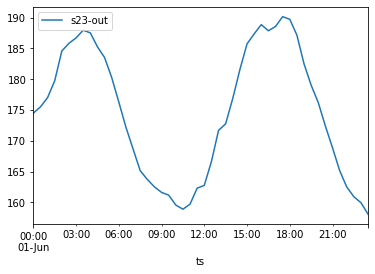

In [5]:
df_raw_pgas['2021-06-01'].resample('30min').mean().plot()

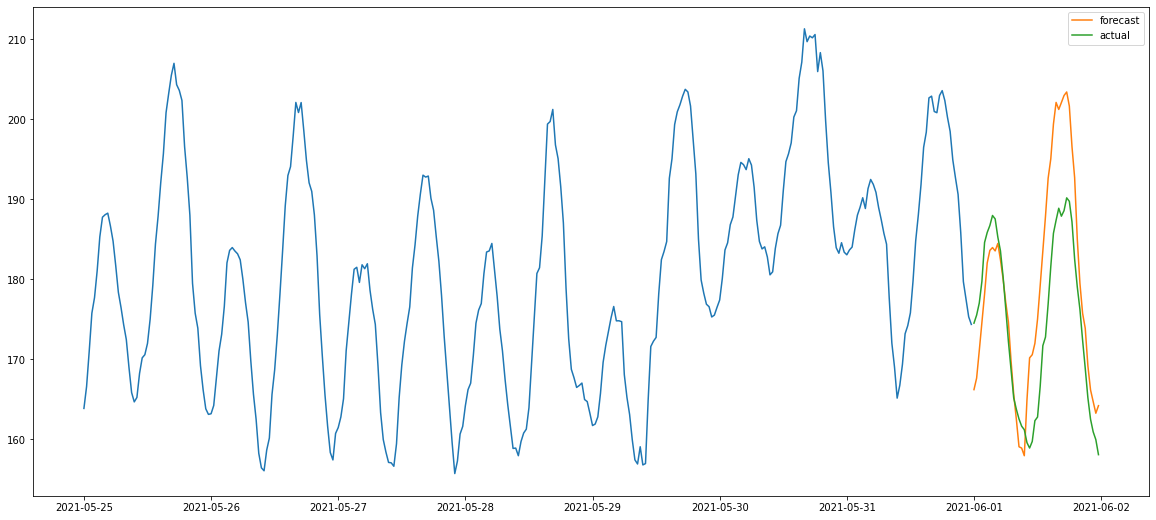

In [6]:
baseline = BaselineModel(freq='30min', horizon='1d')
res_baseline = baseline.fit(df_pgas_pp).predict(df_pgas_pp)
plt.figure(figsize=(20,9))
plt.plot(df_pgas_pp.iloc[-48*7:].index, df_pgas_pp.iloc[-48*7:].values)
plt.plot(res_baseline.index, res_baseline.values, label='forecast')
plt.plot(df_raw_pgas['2021-06-01'].resample('30min').mean().index, df_raw_pgas['2021-06-01'].resample('30min').mean().values, label='actual')
plt.legend()

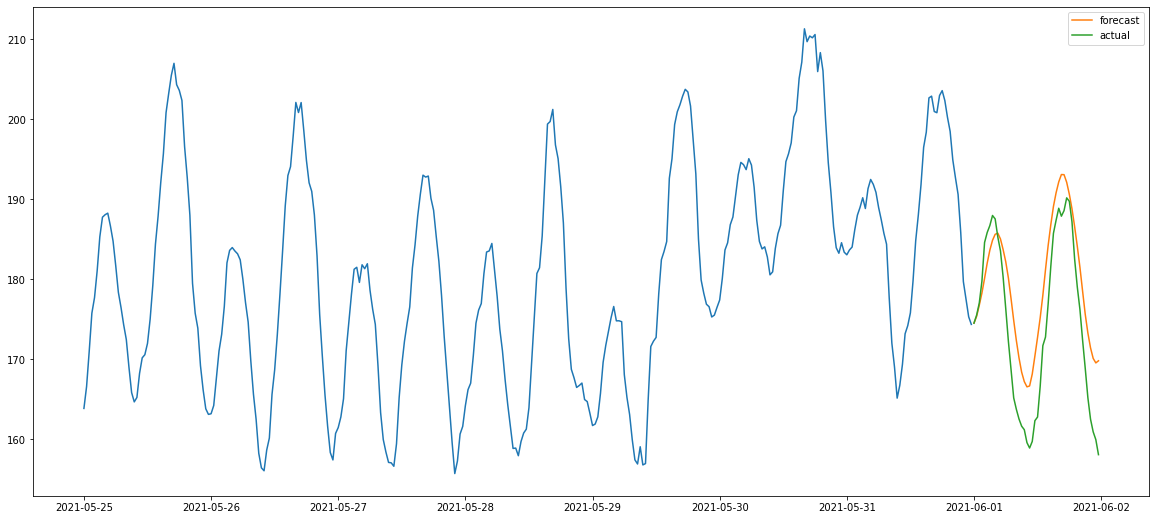

In [7]:
lasso = LinearModel(freq='30min', horizon='1d', cyclic_feature_encoding='onehot')
res_lasso = lasso.fit(df_pgas_pp).predict(df_pgas_pp)
plt.figure(figsize=(20,9))
plt.plot(df_pgas_pp.iloc[-48*7:].index, df_pgas_pp.iloc[-48*7:].values)
plt.plot(res_lasso.index, res_lasso.values, label='forecast')
plt.plot(df_raw_pgas['2021-06-01'].resample('30min').mean().index, df_raw_pgas['2021-06-01'].resample('30min').mean().values, label='actual')
plt.legend()

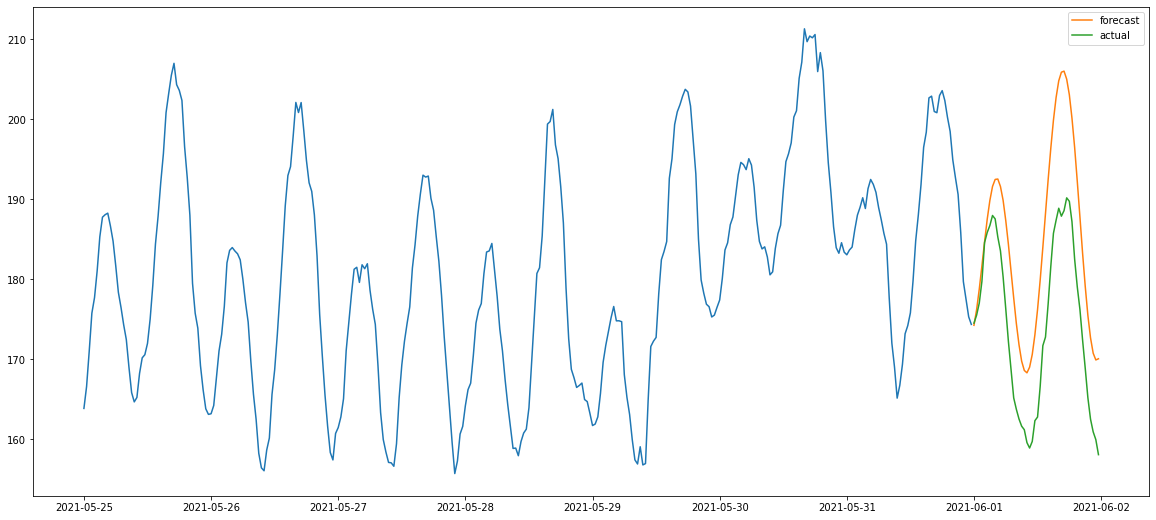

In [8]:
prophet = ProphetModel(freq='30min', horizon='1d', cyclic_feature_encoding='sincos')
res_prophet = prophet.fit(df_pgas_pp).predict(df_pgas_pp)

plt.figure(figsize=(20,9))
plt.plot(df_pgas_pp.iloc[-48*7:].index, df_pgas_pp.iloc[-48*7:].values)
plt.plot(res_prophet.index, res_prophet.values, label='forecast')
plt.plot(df_raw_pgas['2021-06-01'].resample('30min').mean().index, df_raw_pgas['2021-06-01'].resample('30min').mean().values, label='actual')
plt.legend()

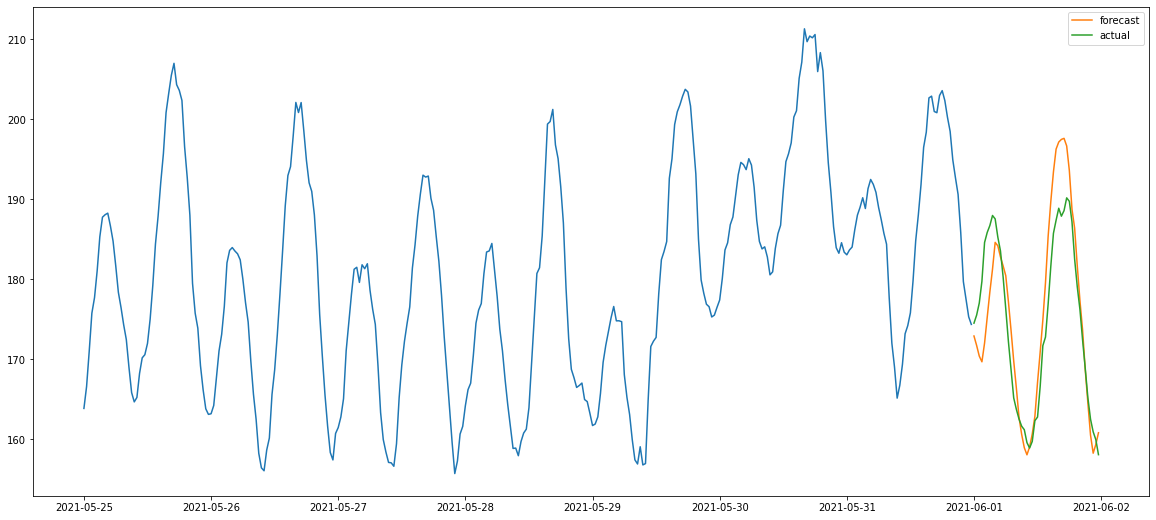

In [9]:
lgb = LGBModel(freq='30min', horizon='1d')
res_lgb = lgb.fit(df_pgas_pp).predict(df_pgas_pp)

plt.figure(figsize=(20,9))
plt.plot(df_pgas_pp.iloc[-48*7:].index, df_pgas_pp.iloc[-48*7:].values)
plt.plot(res_lgb.index, res_lgb.values, label='forecast')
plt.plot(df_raw_pgas['2021-06-01'].resample('30min').mean().index, df_raw_pgas['2021-06-01'].resample('30min').mean().values, label='actual')
plt.legend()

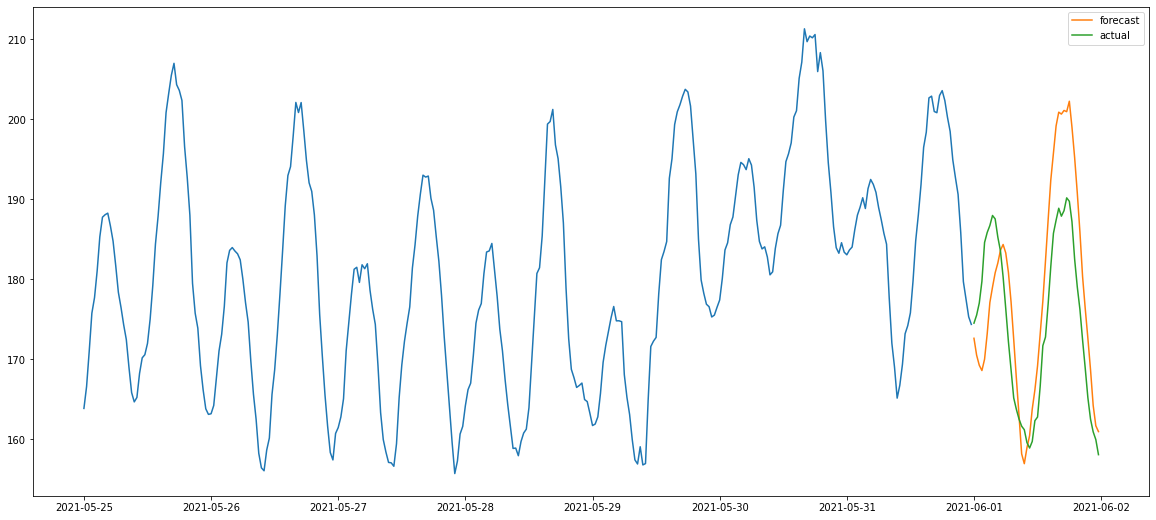

In [10]:
xgb = XGBModel(freq='30min', horizon='1d')
res_xgb = xgb.fit(df_pgas_pp).predict(df_pgas_pp)

plt.figure(figsize=(20,9))
plt.plot(df_pgas_pp.iloc[-48*7:].index, df_pgas_pp.iloc[-48*7:].values)
plt.plot(res_xgb.index, res_xgb.values, label='forecast')
plt.plot(df_raw_pgas['2021-06-01'].resample('30min').mean().index, df_raw_pgas['2021-06-01'].resample('30min').mean().values, label='actual')
plt.legend()

=====Linear model training completed=====
=====Prophet model training completed=====
=====LGB model training completed=====
=====XGB model training completed=====
=====Linear model forecasting completed=====
=====Prophet model forecasting completed=====
=====LGB model forecasting completed=====
=====XGB model forecasting completed=====


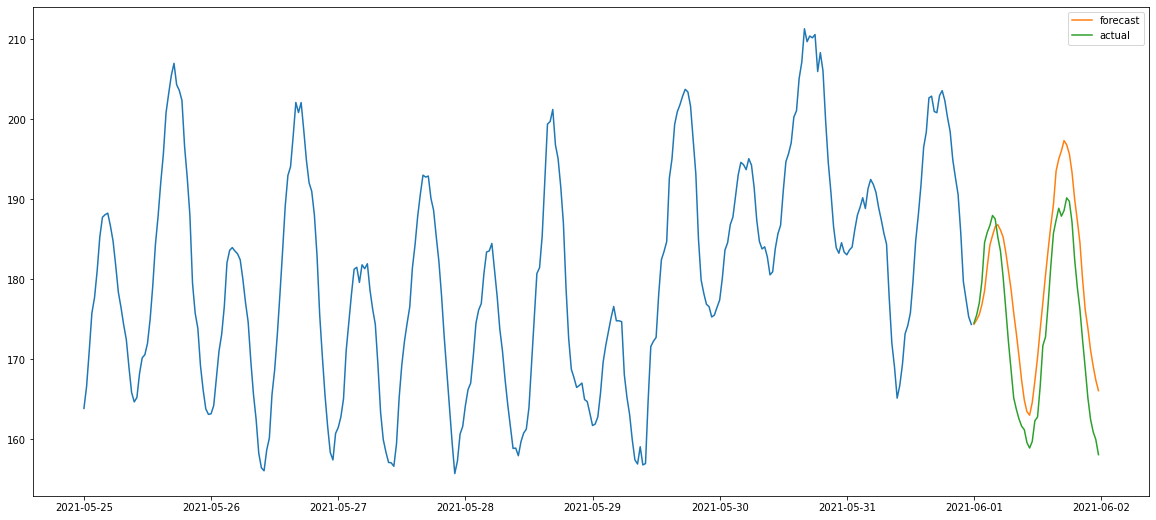

In [11]:
ensemble = EnsembleModel(freq='30min', horizon='1d')
res_ensemble = ensemble.fit(df_pgas_pp).predict(df_pgas_pp)

plt.figure(figsize=(20,9))
plt.plot(df_pgas_pp.iloc[-48*7:].index, df_pgas_pp.iloc[-48*7:].values)
plt.plot(res_ensemble.index, res_ensemble.values, label='forecast')
plt.plot(df_raw_pgas['2021-06-01'].resample('30min').mean().index, df_raw_pgas['2021-06-01'].resample('30min').mean().values, label='actual')
plt.legend()

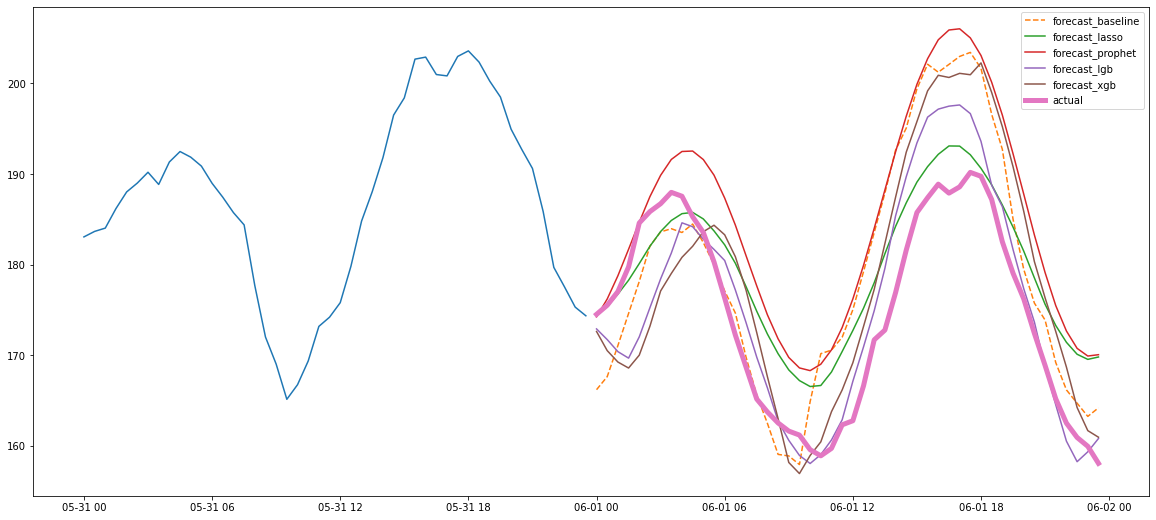

In [12]:
plt.figure(figsize=(20,9))
plt.plot(df_pgas_pp.iloc[-48*1:].index, df_pgas_pp.iloc[-48*1:].values)
plt.plot(res_baseline.index, res_baseline.values, linestyle='--', label='forecast_baseline')
plt.plot(res_lasso.index, res_lasso.values, label='forecast_lasso')
plt.plot(res_prophet.index, res_prophet.values, label='forecast_prophet')
plt.plot(res_lgb.index, res_lgb.values, label='forecast_lgb')
plt.plot(res_xgb.index, res_xgb.values, label='forecast_xgb')
plt.plot(df_raw_pgas['2021-06-01'].resample('30min').mean().index, df_raw_pgas['2021-06-01'].resample('30min').mean().values, linewidth=5, label='actual')
plt.legend()

In [13]:
baseline = BaselineModel(freq='30min', horizon='1d')
lasso = LinearModel(freq='30min', horizon='1d')
prophet = ProphetModel(freq='30min', horizon='1d')
lgb = LGBModel(freq='30min', horizon='1d')
xgb = XGBModel(freq='30min', horizon='1d')

res = []
for f in [baseline, lasso, prophet, lgb, xgb]:
    res_temp = back_test(f, df_pgas_pp, test_size=0.05, stride='1d', retrain_stride=False)
    res_temp['model'] = f.name
    res.append(res_temp)
    print(f'===={f.name} model completed====')

pd.DataFrame(res).set_index('model')

====Baseline model completed====
====Linear model completed====
====Prophet model completed====
====LGB model completed====
====XGB model completed====


,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std
model,,,,,,,,
Baseline,12.848270,181.211213,11.453168,0.061195,4.919323,131.740785,5.148406,0.025490
Linear,10.634992,125.090990,9.836315,0.052157,4.240508,100.066074,4.332698,0.021500
Prophet,10.816399,131.339116,10.127273,0.054283,4.638636,93.697584,4.611111,0.022896
LGB,11.302772,136.459903,10.468638,0.056404,3.613982,89.212921,3.398210,0.016560
XGB,10.444256,119.738900,9.432991,0.050758,3.998076,92.517913,3.584953,0.017783


In [14]:
lasso = LinearModel(freq='30min', horizon='1d')
params = {
    'alpha': [0.01, 0.1, 1],
    'cyclic_feature_encoding': ['sincos', 'onehot']
}
grid_search(lasso, params, df_pgas_pp, test_size=0.05, stride='1d', retrain_stride=False)

100%|██████████| 6/6 [01:41<00:00, 16.85s/it]


,alpha,cyclic_feature_encoding,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std
0,0.01,sincos,9.105087,93.147065,8.157679,0.043746,3.920035,78.682173,3.976338,0.020055
1,0.01,onehot,9.516970,100.856144,8.522267,0.045702,3.927485,81.467031,3.986328,0.020172
2,0.10,sincos,10.635014,125.091246,9.836324,0.052157,4.240470,100.065292,4.332665,0.021500
3,0.10,onehot,10.634992,125.090990,9.836315,0.052157,4.240508,100.066074,4.332698,0.021500
4,1.00,sincos,14.501154,216.081272,12.505166,0.065692,2.949019,90.356487,2.982371,0.012856
5,1.00,onehot,14.501154,216.081272,12.505166,0.065692,2.949019,90.356487,2.982371,0.012856


In [15]:
xgb = XGBModel(freq='30min', horizon='1d')
params = {
    'cyclic_feature_encoding': ['sincos', 'onehot'],
    'max_depth': [6, 7],
    'min_child_weight': [30, 50]
}
grid_search(xgb, params, df_pgas_pp, test_size=0.05, stride='1d', retrain_stride=False)

100%|██████████| 8/8 [05:51<00:00, 43.90s/it]


,cyclic_feature_encoding,max_depth,min_child_weight,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std
0,sincos,6,30,11.043808,130.339539,9.922623,0.053708,3.544118,84.962489,3.593646,0.017294
1,sincos,6,50,11.225888,138.322223,10.367252,0.055720,4.295637,107.095260,4.383608,0.021520
2,sincos,7,30,10.066944,117.368269,9.290390,0.049907,4.902791,109.859927,4.931224,0.024633
3,sincos,7,50,10.185629,112.810895,9.178190,0.049689,3.687245,82.409349,3.607065,0.017757
4,onehot,6,30,11.698709,152.397847,10.918634,0.058585,4.827741,126.066322,4.736026,0.023608
5,onehot,6,50,10.444256,119.738900,9.432991,0.050758,3.998076,92.517913,3.584953,0.017783
6,onehot,7,30,12.468918,169.856094,11.704283,0.062670,4.644704,128.053947,4.694487,0.022947
7,onehot,7,50,11.003047,137.202561,10.080085,0.053925,4.919682,117.169807,5.106132,0.025738


In [16]:
prophet = ProphetModel(freq='30min', horizon='1d')
params = {
    'cyclic_feature_encoding': ['sincos', 'onehot'],
    'growth': ['linear', 'logistic'],
    'seasonality_mode': ['additive', 'multiplicative']
}
grid_search(prophet, params, df_pgas_pp, test_size=0.05, stride='1d', retrain_stride=False)

100%|██████████| 8/8 [01:01<00:00,  7.63s/it]


,cyclic_feature_encoding,growth,seasonality_mode,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std
0,sincos,linear,additive,10.789322,131.418047,10.109252,0.054227,4.744774,98.374202,4.741169,0.023425
1,sincos,linear,multiplicative,10.773881,131.060362,10.099045,0.054167,4.740863,98.486474,4.735747,0.023396
2,sincos,logistic,additive,12.035415,165.801762,11.432172,0.061088,5.605875,125.206540,5.605974,0.028189
3,sincos,logistic,multiplicative,30.404614,926.902434,26.139648,0.141316,1.921663,114.728914,1.547176,0.005556
4,onehot,linear,additive,10.816399,131.339116,10.127273,0.054283,4.638636,93.697584,4.611111,0.022896
5,onehot,linear,multiplicative,10.046313,112.058801,9.251059,0.049744,4.086025,79.150631,4.099056,0.020071
6,onehot,logistic,additive,12.030285,164.223359,11.388038,0.060835,5.407716,118.344640,5.433078,0.027430
7,onehot,logistic,multiplicative,30.483819,931.621891,26.345249,0.142112,1.880950,113.358720,1.597336,0.006899
